# PyTorch Supervised Learning

##### Import Libraries and Set Global Seeds

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [75]:
seed_value = 123
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

##### Read Hotel Data Set

In [76]:
hotel_df = pd.read_csv(r"./hotel_bookings.csv")
pd.set_option('display.max_columns', None)
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


##### Preprocess the Data (Pandas Transformations)

In [77]:
# Make date field
hotel_df['arrival_date_month_day'] = hotel_df['arrival_date_month'] + ' ' + hotel_df['arrival_date_day_of_month'].astype(str)

# Change data types and handle missing values
hotel_df[['is_canceled', 'is_repeated_guest']] = hotel_df[['is_canceled', 'is_repeated_guest']].astype(bool)
hotel_df['children'] = hotel_df['children'].fillna(0).astype(int)
hotel_df[['agent', 'company']] = hotel_df[['agent', 'company']].fillna(0)
hotel_df['country'] = hotel_df['country'].fillna('Unknown')

# Remove unnecessary columns
hotel_df = hotel_df.drop(columns=['arrival_date_day_of_month', 'reservation_status', 'reservation_status_date'])

##### Preprocess the Data (Scikit-Learn Transformations)

In [78]:
# Get target variable and split data in train and test sets
y = hotel_df['is_canceled']
hotel_df = hotel_df.drop(columns=['is_canceled'])

# Identify column types for transformations
numerical_cols = hotel_df.select_dtypes(include=np.number).columns.tolist()
onehot_cols = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type',
               'assigned_room_type', 'deposit_type', 'customer_type']
boolean_cols = hotel_df.select_dtypes(include='bool').columns.tolist()
target_encode_cols = ['country', 'agent', 'company', 'arrival_date_month_day']

# Create ColumnTransformer with one-hot encoding, target encoding, and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_cols),
        ('target', TargetEncoder(), target_encode_cols),
        ('scaler', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Create pipeline with imputation and scaling (shouldn't be strictly necessary after preprocessor, but just to be sure)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [79]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(hotel_df, y, test_size=0.2, random_state=123)

# Fit pipeline on training data before applying it to both data sets
pipeline.fit(x_train, y_train)
x_train = pipeline.transform(x_train)
x_test = pipeline.transform(x_test)

# Convert all data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

##### PyTorch Neural Network Architecture

In [80]:
class wide_nn(nn.Module):                     # 21,166 parameters
    def __init__(self):
        super().__init__()                    # Inherit the properties of parent class nn.Module
        self.hidden = nn.Linear(83, 249)      # First layer has 83 inputs (number of input features) and 249 outputs (x3)
        self.relu = nn.ReLU()                 # ReLU activation function
        self.output = nn.Linear(249, 1)       # Output layer has 249 inputs and 1 output (for binary classification)
        self.sigmoid = nn.Sigmoid()           # Sigmoid activation for continuous output between 0 and 1
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    

class deep_nn(nn.Module):                     # 21,000 parameters
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(83, 83)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(83, 83)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(83, 83)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(83, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

##### Training Loop

In [81]:
def train_model(model, x_train, y_train, x_val, y_val):
    loss_function = nn.BCELoss()                                                       # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)                               # Adam optimizer
 
    n_epochs = 50
    batch_size = 500
    batch_start = torch.arange(0, len(x_train), batch_size)                            # Batch start indices
 
    # Hold the best model
    best_accuracy = -np.inf                                                            # Initialize to negative infinity
    best_weights = None

    # Store epoch accuracies
    epoch_accuracies = []
 
    for epoch in range(n_epochs):
        model.train()                                                                  # Set model to training mode
        
        # Shuffle the training data at the start of each epoch
        permutation = torch.randperm(x_train.size(0))
        x_train = x_train[permutation]
        y_train = y_train[permutation]
 
        for start in batch_start:
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # Forward pass (compute predictions and loss with current weights)
            y_pred = model(x_batch)
            loss = loss_function(y_pred, y_batch)
            
            # Backward pass (compute gradients with current loss)
            optimizer.zero_grad()                                                      # Clear previous gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
        
        # Evaluate on test set
        model.eval()                                                                   # Set model to evaluation mode
        with torch.no_grad():
            y_val_pred = model(x_val)
            y_val_pred_labels = (y_val_pred >= 0.5).float()
            accuracy = (y_val_pred_labels.eq(y_val).sum().item()) / len(y_val)
            epoch_accuracies.append(accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_weights = copy.deepcopy(model.state_dict())                       # Save the weights of the best model

        #print(f'Epoch [{epoch+1}/{n_epochs}], Accuracy: {best_accuracy:.4f}')
    
    # Load best weights
    model.load_state_dict(best_weights)                                                # Load best model weights
    return model, epoch_accuracies

##### K-Fold Cross-Validation (Wide Neural Network)

In [82]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
best_accuracy = 0.0

for train_idx, test_idx in kfold.split(x_train, y_train):
    # Create model, train it, and get its accuracy for each fold
    model = wide_nn()
    current_model, epoch_accuracies = train_model(model, x_train[train_idx], y_train[train_idx], x_train[test_idx], y_train[test_idx])
    accuracy = epoch_accuracies[-1]
    print(f"Accuracy for fold {len(cv_scores)+1}: {accuracy:.4f}")
    cv_scores.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_wide_model = current_model
 
# Evaluate the model
accuracy = np.mean(cv_scores)*100
std = np.std(cv_scores)*100
print(f"Model accuracy: {accuracy:.2f}% (+/- {std:.2f}%)")

# Save the best model
torch.save(best_wide_model.state_dict(), 'wide_nn.pth')

Accuracy for fold 1: 0.8645
Accuracy for fold 2: 0.8717
Accuracy for fold 3: 0.8674
Accuracy for fold 4: 0.8641
Accuracy for fold 5: 0.8672
Model accuracy: 86.70% (+/- 0.27%)


##### Accuracy Curve (Wide Neural Network)

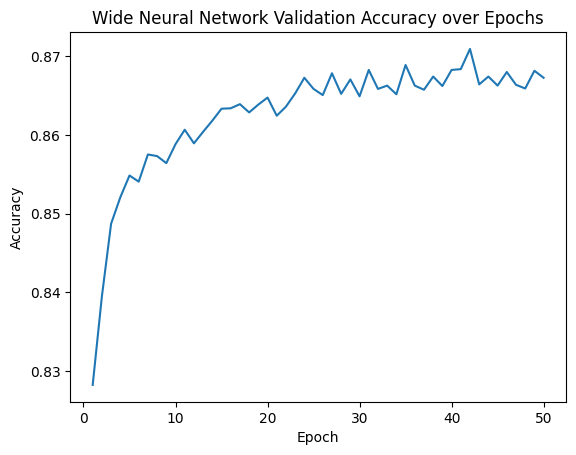

In [83]:
# Plot accuracy over epochs for the last fold
plt.plot(range(1, len(epoch_accuracies)+1), epoch_accuracies)
plt.title('Wide Neural Network Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##### Confusion Matrix (Wide Neural Network)

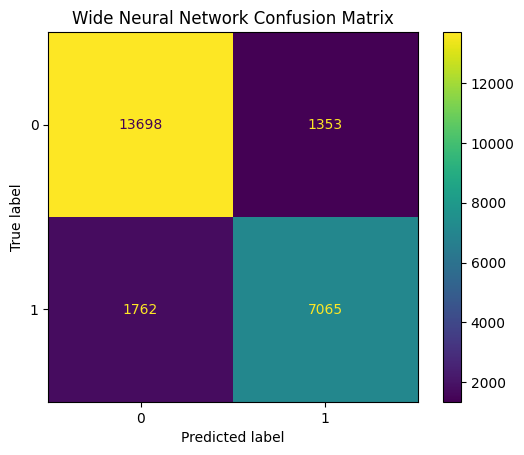

In [84]:
y_pred_np = (best_wide_model(x_test) > 0.5).detach().numpy()
y_test_np = y_test.detach().numpy()

display = ConfusionMatrixDisplay(confusion_matrix(y_test_np, y_pred_np))
display.plot()
plt.title('Wide Neural Network Confusion Matrix')
plt.show()

##### Performance Metrics (Wide Neural Network)

In [86]:
roc_auc = roc_auc_score(y_test_np, y_pred_np)
pr_auc = average_precision_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

baseline_accuracy = y_test_np.mean()
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

Baseline Accuracy: 0.3697
ROC-AUC: 0.8552
PR-AUC: 0.7455
F1 Score: 0.8194


##### K-Fold Cross-Validation (Deep Neural Network)

In [87]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
best_accuracy = 0.0

for train_idx, test_idx in kfold.split(x_train, y_train):
    # Create model, train it, and get its accuracy for each fold
    model = deep_nn()
    current_model, epoch_accuracies = train_model(model, x_train[train_idx], y_train[train_idx], x_train[test_idx], y_train[test_idx])
    accuracy = epoch_accuracies[-1]
    print(f"Accuracy for fold {len(cv_scores)+1}: {accuracy:.4f}")
    cv_scores.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_deep_model = current_model
 
# Evaluate the model
accuracy = np.mean(cv_scores)*100
std = np.std(cv_scores)*100
print(f"Model accuracy: {accuracy:.2f}% (+/- {std:.2f}%)")

# Save the best model
torch.save(best_deep_model.state_dict(), 'deep_nn.pth')

Accuracy for fold 1: 0.8666
Accuracy for fold 2: 0.8657
Accuracy for fold 3: 0.8662
Accuracy for fold 4: 0.8625
Accuracy for fold 5: 0.8660
Model accuracy: 86.54% (+/- 0.15%)


##### Accuracy Curve (Deep Neural Network)

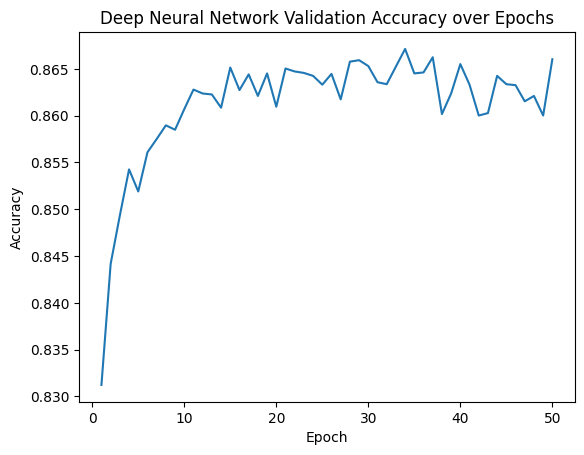

In [88]:
# Plot accuracy over epochs for the last fold
plt.plot(range(1, len(epoch_accuracies)+1), epoch_accuracies)
plt.title('Deep Neural Network Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##### Confusion Matrix (Deep Neural Network)

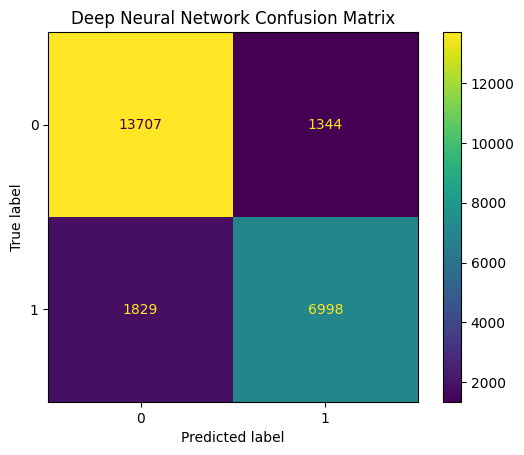

In [89]:
y_pred_np = (best_deep_model(x_test) > 0.5).detach().numpy()
y_test_np = y_test.detach().numpy()

display = ConfusionMatrixDisplay(confusion_matrix(y_test_np, y_pred_np))
display.plot()
plt.title('Deep Neural Network Confusion Matrix')
plt.show()

##### Performance Metrics (Deep Neural Network)

In [90]:
roc_auc = roc_auc_score(y_test_np, y_pred_np)
pr_auc = average_precision_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

baseline_accuracy = y_test_np.mean()
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

Baseline Accuracy: 0.3697
ROC-AUC: 0.8517
PR-AUC: 0.7417
F1 Score: 0.8152
